# Goal 1: Planck-Like likelihood

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%env OMP_NUM_THREADS=20

env: OMP_NUM_THREADS=20


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
fiducial_params = {
    'omega_b': 0.0224, 'omega_cdm': 0.12, 
    '100*theta_s': 1.0416, 'tau_reio': 0.07,
    'A_s': 2.2e-9, 'n_s': 0.96,
    'N_ur': 2.0328, 'N_ncdm': 1, 'm_ncdm': 0.06, 'T_ncdm': 0.71611,}

l_max = 2000

modules_path = '/home/zequnl/src/cobaya_modules'

info_fiducial = {
    'params': fiducial_params,
    'likelihood': {'one': None},
    'theory': {
        'classy': None
        
    }
}

from cobaya.model import get_model
model_fiducial = get_model(info_fiducial)

# Declare our desired theory product
# (there is no cosmological likelihood doing it for us)
model_fiducial.likelihood.theory.needs(Cl={'tt': l_max})

# Compute and extract the CMB power spectrum
# (In muK^-2, without l(l+1)/(2pi) factor)
# notice the empty dictionary below: all parameters are fixed
model_fiducial.logposterior({})
Cls = model_fiducial.likelihood.theory.get_Cl(ell_factor=False)

# Our fiducial power spectrum
Cl_est = Cls['tt'][:l_max+1]

[prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[classy] Importing *global* CLASS.


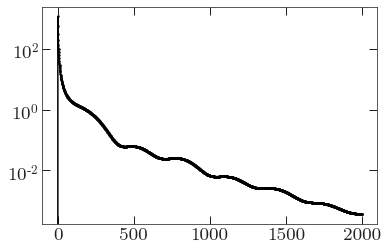

In [4]:
plt.plot(Cl_est)
plt.yscale('log')

In [5]:
def my_like(
        # Parameters that we may sample over (or not)
        beam_FWHM=0.25,  # deg
        # Declaration of our theory requirements
        _theory={'Cl': {'tt': l_max}},
        # Declaration of available derived parameters
        _derived={'Map_Cl_at_500': None}):
    
    # Noise spectrum, beam-corrected
    healpix_Nside=512
    noise_std_pixel= 20
    pixel_area_rad = np.pi/(3*healpix_Nside**2)
    weight_per_solid_angle = (noise_std_pixel**2 * pixel_area_rad)**-1
    beam_sigma_rad = beam_FWHM / np.sqrt(8*np.log(2)) * np.pi/180.
    ells = np.arange(l_max+1)
    Nl = np.exp((ells*beam_sigma_rad)**2)/weight_per_solid_angle
    # Cl of the map: data + noise
    Cl_map = Cl_est + Nl
    # Cl from theory: treat '_theory' as a 'theory code instance'
    Cl_theo = _theory.get_Cl(ell_factor=False)['tt'][:l_max+1]  # muK-2
    Cl_map_theo = Cl_theo + Nl
    # Set our derived parameter, assuming '_derived' is a dictionary
    _derived['Map_Cl_at_500'] = Cl_map[500]
    
    
    # Auxiliary plot
#     ell_factor = ells*(ells+1)/(2*np.pi)
#     plt.figure()
#     plt.plot(ells[2:], (Cl_theo*ell_factor)[2:], label=r'Theory $C_\ell$')
#     plt.plot(ells[2:], (Cl_est*ell_factor)[2:], label=r'Estimated $C_\ell$')
#     plt.plot(ells[2:], (Cl_map*ell_factor)[2:], label=r'Map $C_\ell$')
#     plt.plot(ells[2:], (Nl*ell_factor)[2:], label='Noise')
#     plt.legend()
#     plt.ylim([0, 6000])

    # ----------------
    # Compute the log-likelihood
    V = Cl_map[2:]/Cl_map_theo[2:]
    return np.sum((2*ells[2:]+1)*(-V/2 +1/2.*np.log(V)))

In [6]:
my_like(_theory=model_fiducial.likelihood.theory)

-2001998.5

In [27]:
info = {
    'params': {
        # Fixed
        'N_ur': 2.0328, 'N_ncdm': 1, 'm_ncdm': 0.06, 'T_ncdm': 0.71611,
        # Sampled
        
        'logA': {
            'prior': {'min': 1.61, 'max': 3.91}, 
            'ref' : {'dist' : 'norm', 'loc' : 3.05, 'scale' : 0.001},
            'proposal' : 0.001,
            'latex': '\log(10^{10} A_\mathrm{s})', 
            'drop': True
        },
        'n_s': {
            'prior': {'min': 0.9, 'max': 1.1}, 
            'ref' : {'dist' : 'norm', 'loc' : 0.965, 'scale' : 0.004},
            'proposal' : 0.002,
            'latex': 'n_s'
        },
        'omega_b': {
            'prior': {'min': 0.005, 'max': 0.1}, 
            'ref' : {'dist' : 'norm', 'loc' : 0.0224, 'scale' : 0.0001},
            'proposal' : 0.0001,
            'latex': '\Omega_\mathrm{b} h^2'
        },
        'omega_cdm': {
            'prior': {'min': 0.001, 'max': 0.99}, 
            'ref' : {'dist' : 'norm', 'loc' : 0.12, 'scale' : 0.001},
            'proposal' : 0.0005,
            'latex': '\Omega_\mathrm{c} h^2'
        },
        'theta_s_1e2' : {
            'prior': {'min': 0.5, 'max': 10.0}, 
            'ref' : {'dist' : 'norm', 'loc' : 1.0416, 'scale' : 0.0004},
            'proposal' : 0.0002,
            'latex': '100\theta_\mathrm{s}', 
            'drop': True
        },
        '100*theta_s' : {
            'value': 'lambda theta_s_1e2: theta_s_1e2',
            'derived': False
        },
        'tau_reio': {
            'prior': {'min': 0.01, 'max': 0.08}, 
            'ref' : {'dist' : 'norm', 'loc' : 0.055, 'scale' : 0.006},
            'proposal' : 0.003,
            'latex': '\tau_\mathrm{reio}'
        },
        # Derived
        
        'A_s': {'value':'lambda logA: 1e-10*np.exp(logA)', 'latex': 'A_s'},
        'H0' : {'latex':'H_0'},
        
    },
    'likelihood': {'my_cl_like': my_like},
    'theory': {'classy' : None},
    'sampler': {
        'mcmc': {
            'covmat' : 'chains/class_bluebook.covmat',
            'proposal_scale' : 2.4
        }
    },
#     'sampler': {
#         'polychord': None
#     },  # or polychord...

#     'resume' : True,
    'force' : True,
    
#     'modules': modules_path,
    'output': 'chains/class_bluebook'}

In [28]:
from cobaya.model import get_model
model = get_model(info)

[model] *WARNING* Ignored blocks/options: ['sampler', 'force', 'output']
[my_cl_like] Initialised external likelihood.
[classy] Importing *global* CLASS.
[likelihood] The theory code will compute the following products, requested by the likelihoods: ['H0', 'Cl']


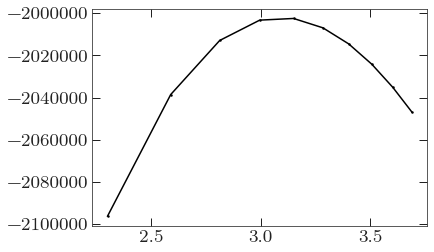

In [29]:
As = np.log(1e10 * np.linspace(1e-9, 4e-9, 10))

par = fiducial_params.copy()
del par['100*theta_s']
del par['A_s']
likes = [model.loglike({**par, **{'logA': A,
                                 'theta_s_1e2':1.042}})[0] for A in As]

plt.figure()
plt.plot(As, likes)
plt.show()

In [ ]:
from cobaya.run import run
updated_info, products = run(info)

[output] Output to be read-from/written-into folder 'chains', with prefix 'class_bluebook'
[output] Found existing products with the requested ouput prefix: 'chains/class_bluebook'
[output] Deleting previous chain ('force' was requested).
[my_cl_like] Initialised external likelihood.
[classy] Importing *global* CLASS.
[likelihood] The theory code will compute the following products, requested by the likelihoods: ['H0', 'Cl']
[mcmc] Covariance matrix loaded for params ['logA', 'n_s']
[mcmc] Missing proposal covariance for params ['omega_b', 'omega_cdm', 'theta_s_1e2', 'tau_reio']
[mcmc] Covariance matrix not complete. We will start learning the covariance of the proposal earlier: R-1 = 30 (was 2).
[mcmc] Initial point:
[mcmc] 
 weight  minuslogpost      logA       n_s   omega_b  omega_cdm  theta_s_1e2  tau_reio           A_s       H0  \
    1.0  2.002118e+06  3.049515  0.967067  0.022352   0.118876     1.041605  0.065446  2.110512e-09  67.6656   

 minuslogprior  minuslogprior__0       

In [1]:
from getdist import loadMCSamples

# gd_sample = MCSamplesFromCobaya(updated_info, products["sample"])
gd_sample = loadMCSamples("chains/class_bluebook")

chains/class_bluebook.1.txt
Removed no burn in


In [ ]:
gd_sample.paramNames.setLabels(['logA', 'n_s',r'\omega_b',r'\omega_{cdm}',r'100 \theta_S',r'\tau_{reio}','A_s','H_0'])

In [3]:
# Export the results to GetDist
# Analyze and plot
mean = gd_sample.getMeans()[:2]
covmat = gd_sample.getCovMat().matrix[:2, :2]
print("Mean:")
print(mean)
print("Covariance matrix:")
print(covmat)

%matplotlib inline
import getdist.plots as gdplt
gdplot = gdplt.getSubplotPlotter()
gdplot.triangle_plot(gd_sample, ['n_s','omega_b','omega_cdm','theta_s_1e2','tau_reio','A_s','H0'], filled=True)

Mean:
[3.04131162 0.95609154]
Covariance matrix:
[[1.62782304e-03 7.54603816e-05]
 [7.54603816e-05 9.92823619e-05]]
